In [2]:
# import system modules
import sys
import os
import gc

# import standard numerical modules
import numpy as np
import math

import matplotlib.pyplot as plt

# import machine learning modules
import tensorflow as tf
import keras.backend as K

sys.path.append('../20240503')
import DCTR


# Process Data

In [3]:
data_dir = '/home/finn/pythia_examples_naf/output/' # '../Data'
num_events = 100000


In [5]:
# load datasets created in commented out cells above ^
# and n-jettiness datasets created with python scripts on NAF
X0_showered = np.load(f'{data_dir}/hvq/converted_lhe_hvq_dileptonic.npy')[:num_events]

# nrm data and save to disk (only needed to run once)
nrm_array_dir = '/home/finn/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/Data/POWHEG_hvq/showered/'
nrm_array = np.load(f'{nrm_array_dir}/norm_array_lhe_01.npy')
X0_nrm, _ = DCTR.normalize_data(X0_showered.copy(), nrm_array)
np.save(f'{data_dir}/hvq/normed_lhe_hvq_dileptonic.npy', X0_nrm)

X0_nrm = np.load(f'{data_dir}/hvq/normed_lhe_hvq_dileptonic.npy')[:num_events]

X0_nJets = np.load(f'{data_dir}/hvq/jet_multiplicity_hvq_dileptonic.npy')[:num_events]
X0_wgt = X0_nJets[:,1]

X0_jet = np.load(f'{data_dir}/hvq/jet_4vectors_hvq_dileptonic.npy')


print(f'{np.shape(X0_showered)  = }')
print(f'{np.shape(X0_nrm)       = }')
print(f'{np.shape(X0_nJets)     = }')
print(f'{np.shape(X0_wgt)       = }')
print(f'{np.shape(X0_jet)       = }')


np.shape(X0_showered)  = (100000, 3, 9)
np.shape(X0_nrm)       = (100000, 3, 9)
np.shape(X0_nJets)     = (100000, 2)
np.shape(X0_wgt)       = (100000,)
np.shape(X0_jet)       = (100000, 20, 6)


In [24]:
# MiNNLO | only 10k events per lhe

X1_showered = []
X1_nJets = []
X1_jet = []
for i in range(11):
    X1_showered.extend(np.load(f'{data_dir}/MiNNLO/converted_lhe_MiNNLO_{990 + i:04d}.npy'))
    X1_nJets.extend(np.load(f'{data_dir}/MiNNLO/jet_multiplicity_MiNNLO_{990 + i:04d}.npy'))
    X1_jet.extend(np.load(f'{data_dir}/MiNNLO/jet_4vectors_MiNNLO_{990 + i:04d}.npy'))

X1_showered = X1_showered[:num_events]
X1_nJets = np.array(X1_nJets[:num_events])
X1_jet = np.array(X1_jet[:num_events])

# nrm data and save to disk (only needed to run once)
# X1_nrm, _ = DCTR.normalize_data(X1_showered.copy(), nrm_array)
# np.save(f'{data_dir}/hvq/normed_lhe_MiNNLO.npy', X1_nrm)

# X1_nrm = np.load(f'{data_dir}/hvq/normed_lhe_MiNNLO.npy')[:num_events]


X1_wgt = X1_nJets[0:100000, 1]


print(f'{np.shape(X1_showered)  = }')
# print(f'{np.shape(X1_nrm)       = }')
print(f'{np.shape(X1_nJets)     = }')
print(f'{np.shape(X1_wgt)       = }')
print(f'{np.shape(X1_jet)       = }')


np.shape(X1_showered)  = (100000, 3, 9)
np.shape(X1_nJets)     = (100000, 2)
np.shape(X1_wgt)       = (100000,)
np.shape(X1_jet)       = (100000, 20, 6)


In [25]:
print(f'{(X0_nJets[:20])     = }')
# print(f'{(X0_nJets_old[:20]) = }')
print(f'{(X1_nJets[:20])     = }')
# print(f'{(X1_nJets_old[:20]) = }')

# print(f'{max(X0_nJets)     = }')
# print(f'{max(X0_nJets_old) = }')
# print(f'{max(X1_nJets)     = }')
# print(f'{max(X1_nJets_old) = }')


(X0_nJets[:20])     = array([[4.     , 8.07158],
       [4.     , 8.07158],
       [2.     , 8.07158],
       [2.     , 8.07158],
       [4.     , 8.07158],
       [3.     , 8.07158],
       [4.     , 8.07158],
       [3.     , 8.07158],
       [3.     , 8.07158],
       [4.     , 8.07158],
       [4.     , 8.07158],
       [5.     , 8.07158],
       [5.     , 8.07158],
       [5.     , 8.07158],
       [3.     , 8.07158],
       [3.     , 8.07158],
       [6.     , 8.07158],
       [4.     , 8.07158],
       [2.     , 8.07158],
       [5.     , 8.07158]])
(X1_nJets[:20])     = array([[   3.   ,  103.245],
       [   2.   ,  103.245],
       [   5.   , -103.245],
       [   1.   ,  103.245],
       [   3.   ,  103.245],
       [   3.   ,  103.245],
       [   2.   ,  103.245],
       [   5.   ,  103.245],
       [   1.   ,  103.245],
       [   3.   ,  103.245],
       [   2.   ,  103.245],
       [   3.   ,  103.245],
       [   3.   ,  103.245],
       [   6.   , -103.245],
       [ 

In [18]:
# delete energy from (normalized) testing dataset, since the neural network was trained without these parameters
X0_nrm = np.delete(X0_nrm, 5, -1) # E
X0_nrm = np.delete(X0_nrm, 4, -1) # eta
# garbage collection after deleting to clear memory asap
print(gc.collect())


697


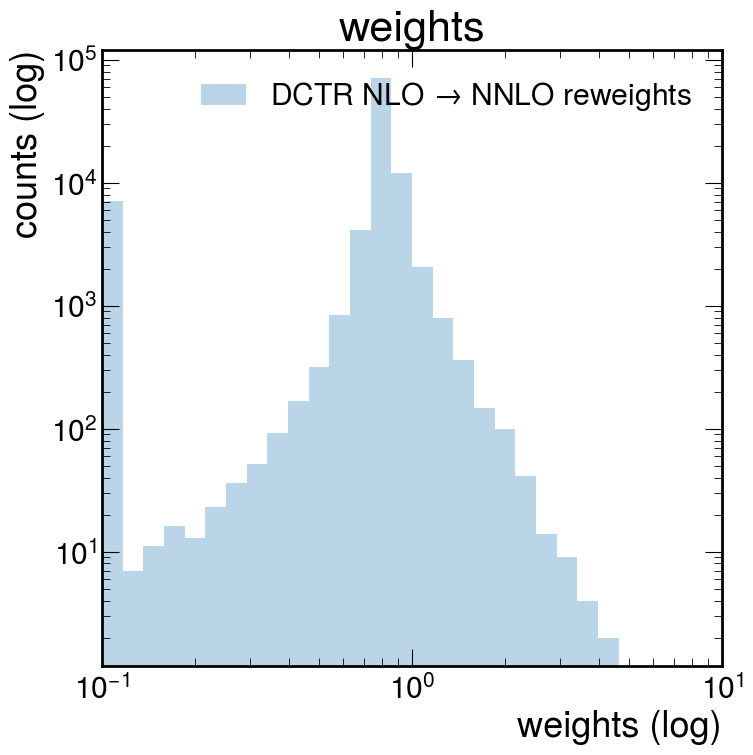

In [26]:
# get rwgt and compare hvq before and after rwgt


# calculate weights from DCTR
model = '../20240521_showered_new/train_20240522/super_epoch_6/run_0/s-6_b-131072_r-0.tf' # path to previously trained model (in .tf format (folder)) for showered events


# calculate rwgt
with tf.device('CPU'):
    dctr_rwgt = DCTR.get_rwgt([model], X0_nrm) # .tf models also include network architecture. get_rwgt() sets up the network for the (list of) models, then calls predict_weights() like in DCTR_notebook_OLD_14-to-13TeV notebook
# plot and check dctr rwgt
wgts = [(dctr_rwgt[0], r'DCTR NLO $\to$ NNLO reweights')]
DCTR.plot_weights(wgts, start = 0.1, stop = 10)

# apply orginal generator weights to rwgt
rwgt = np.multiply(dctr_rwgt[0], X0_wgt)


In [27]:
print(X1_wgt)

[ 103.245  103.245 -103.245 ...  103.245  103.245  103.245]


In [28]:
print(np.shape(X1_nJets))
print(np.shape(X1_wgt))

print(np.shape(X0_nJets))
print(np.shape(X0_wgt))

print(np.shape(rwgt))

(100000, 2)
(100000,)
(100000, 2)
(100000,)
(100000,)


/home/finn/DCTR_Paper/DCTR_FP/20240603_shower_jets/../20240503/DCTR.py:1393: RuntimeWarning: invalid value encountered in true_divide
  ratio_0 = hist0 / hist0
/home/finn/DCTR_Paper/DCTR_FP/20240603_shower_jets/../20240503/DCTR.py:1394: RuntimeWarning: invalid value encountered in true_divide
  ratio_1 = hist1 / hist0
/home/finn/DCTR_Paper/DCTR_FP/20240603_shower_jets/../20240503/DCTR.py:1395: RuntimeWarning: invalid value encountered in true_divide
  ratio_2 = hist2 / hist0
'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


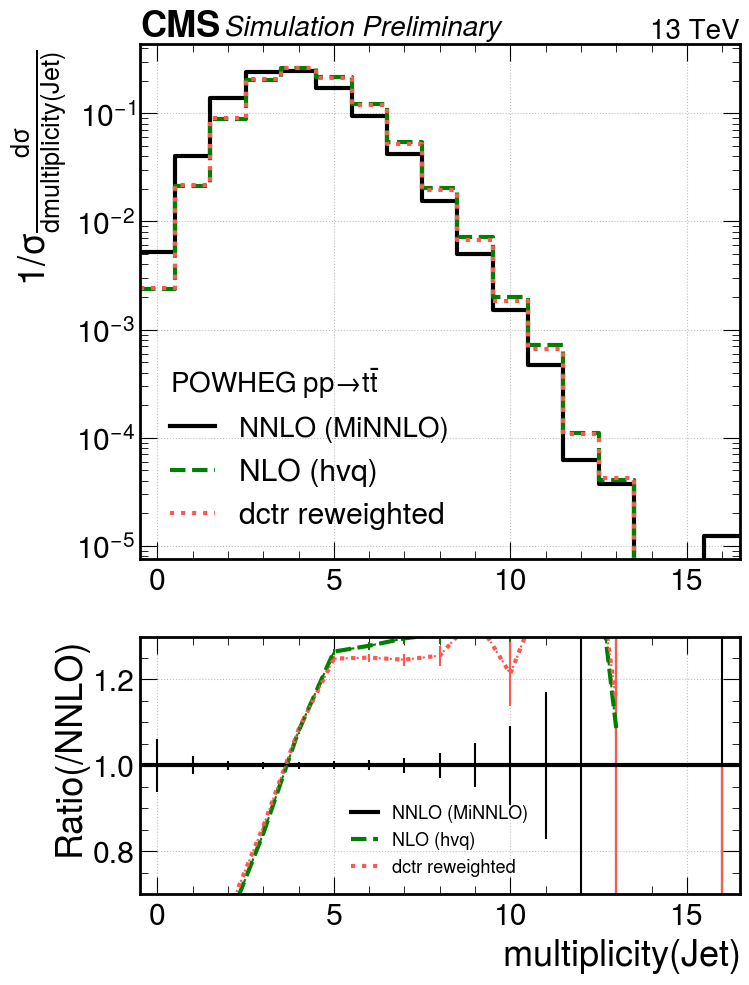

In [29]:
args_multiplicity = [(X1_nJets[:,0], X1_wgt, 'NNLO (MiNNLO)'),
                     (X0_nJets[:,0], X0_wgt, 'NLO (hvq)'),
                     (X0_nJets[:,0], rwgt, 'dctr reweighted')]


bins = np.linspace(-0.5, 16.5, 18)

DCTR.plot_ratio_cms(args_multiplicity, bins = bins, y_scale = 'log', ratio_ylim=[0.7, 1.3], part_label='Jet', arg_label='multiplicity', unit='', inv_unit='')


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


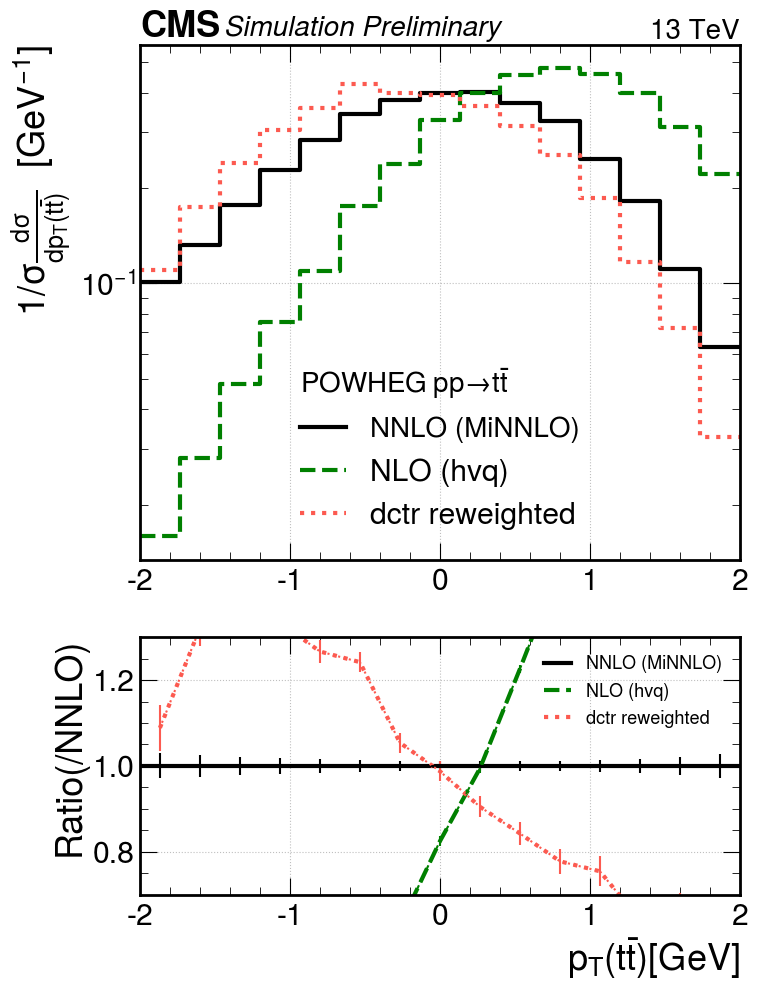

In [ ]:
args_test = [(X1_nrm, X1_wgt, 'NNLO (MiNNLO)'),
                     (X0_nrm, X0_wgt, 'NLO (hvq)'),
                     (X0_nrm, rwgt, 'dctr reweighted')]


bins = np.linspace(-2, 2, 16)

DCTR.plot_ratio_cms(args_test, bins = bins, y_scale = 'log', ratio_ylim=[0.7, 1.3]) #, part_label='Jet', arg_label='multiplicity', unit='', inv_unit='')




/home/finn/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240521_showered_new/../20240503/DCTR.py:1781: RuntimeWarning: invalid value encountered in true_divide
  ratio_0 = hist0 / hist0
/home/finn/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240521_showered_new/../20240503/DCTR.py:1782: RuntimeWarning: invalid value encountered in true_divide
  ratio_1 = hist1 / hist0
'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


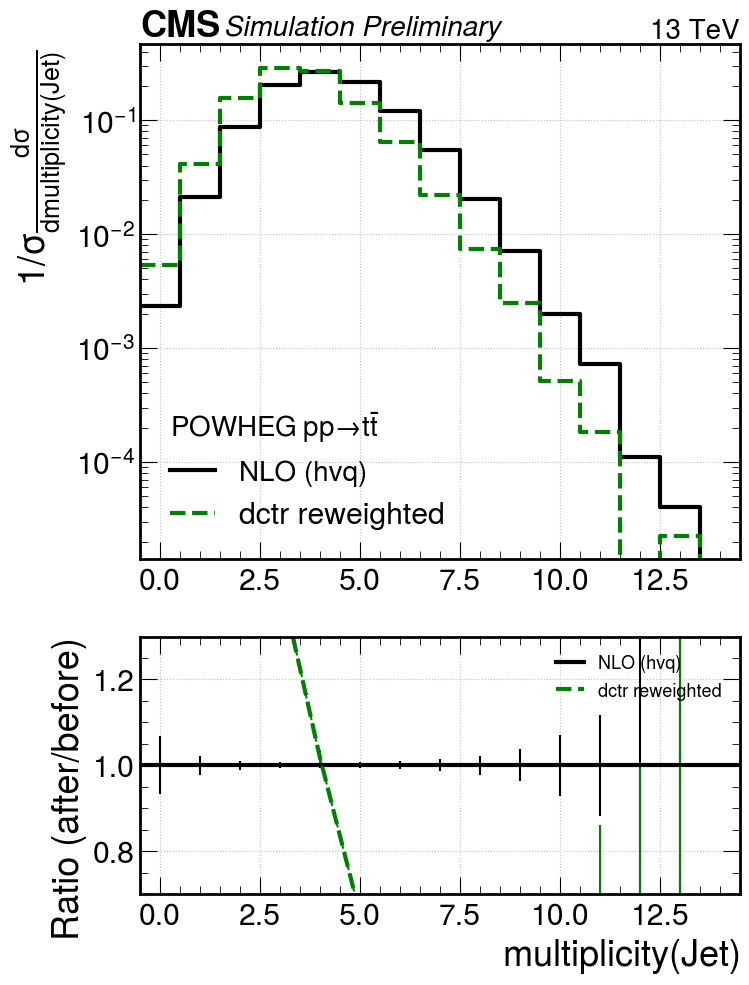

In [17]:
args_hvq = [(X0_nJets, X0_wgt, 'NLO (hvq)'),
            (X0_nJets, rwgt, 'dctr reweighted')]


bins = np.linspace(-0.5, 14.5, 16)

DCTR.plot_ratio_cms_2(args_hvq, bins = bins, y_scale = 'log', ratio_ylim=[0.7, 1.3], part_label='Jet', arg_label='multiplicity', unit='', inv_unit='')


In [16]:
X0_jet = np.load(f'{data_dir}/Jets/jet_4vectors_hvq_dileptonic.npy')[:num_events]
X1_jet = []
for i in range(11):
    X1_jet.extend(np.load(f'{data_dir}/Jets/jet_4vectors_MiNNLO_{990 + i:04d}.npy'))

X1_jet = np.array(X1_jet)[:num_events]

print(f'{np.shape(X0_jet) = }')
print(f'{np.shape(X1_jet) = }')



np.shape(X0_jet) = (100000, 20, 6)
np.shape(X1_jet) = (100000, 20, 6)


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


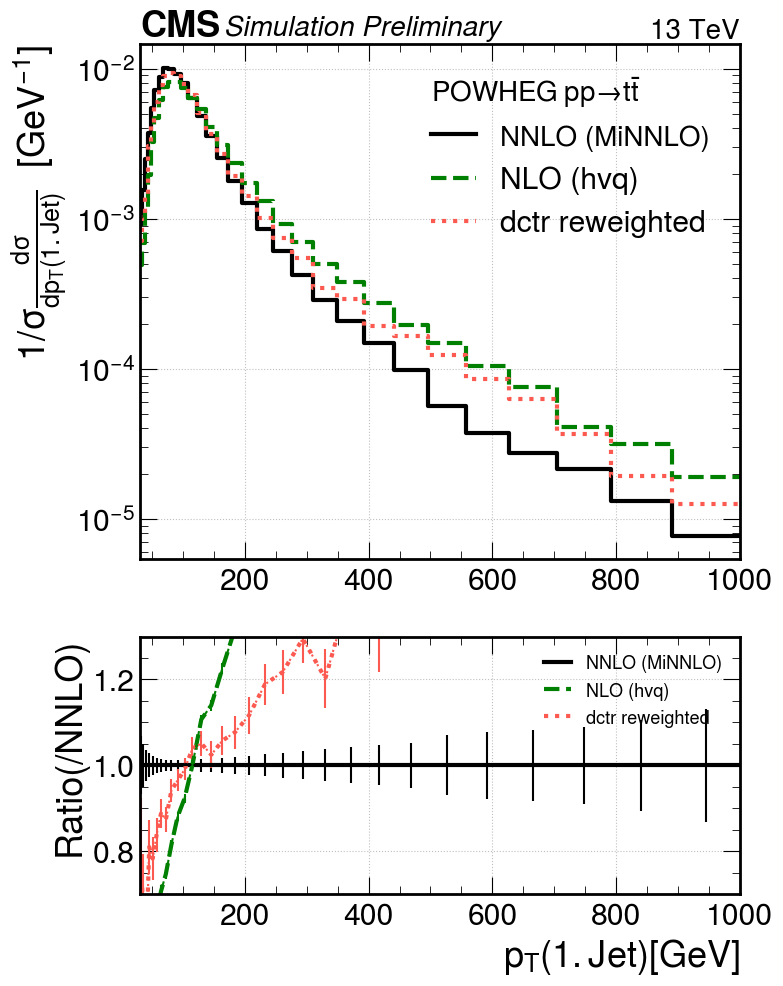

In [20]:
log_bins = np.logspace(np.log10(30), np.log10(1000), 31)

args_jet_0 = [(X1_jet[:, 0, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet[:, 0, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet[:, 0, 0], rwgt, 'dctr reweighted')]

DCTR.plot_ratio_cms(args_jet_0, bins = log_bins, y_scale = 'log', part_label='1. Jet', ratio_ylim=(0.7, 1.3))


args_jet_1 = [(X1_jet[:, 1, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet[:, 1, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet[:, 1, 0], rwgt, 'dctr reweighted')]

# DCTR.plot_ratio_cms(args_jet_1, bins = log_bins, y_scale = 'log', part_label='2. Jet')


args_jet_2 = [(X1_jet[:, 2, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet[:, 2, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet[:, 2, 0], rwgt, 'dctr reweighted')]

# DCTR.plot_ratio_cms(args_jet_2, bins = log_bins, y_scale = 'log', part_label='3. Jet')


args_jet_3 = [(X1_jet[:, 3, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet[:, 3, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet[:, 3, 0], rwgt, 'dctr reweighted')]

# DCTR.plot_ratio_cms(args_jet_3, bins = log_bins, y_scale = 'log', part_label='4. Jet')


np.shape(X0_jet_pt_sums) = (100000,)
np.shape(X1_jet_pt_sums) = (100000,)


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


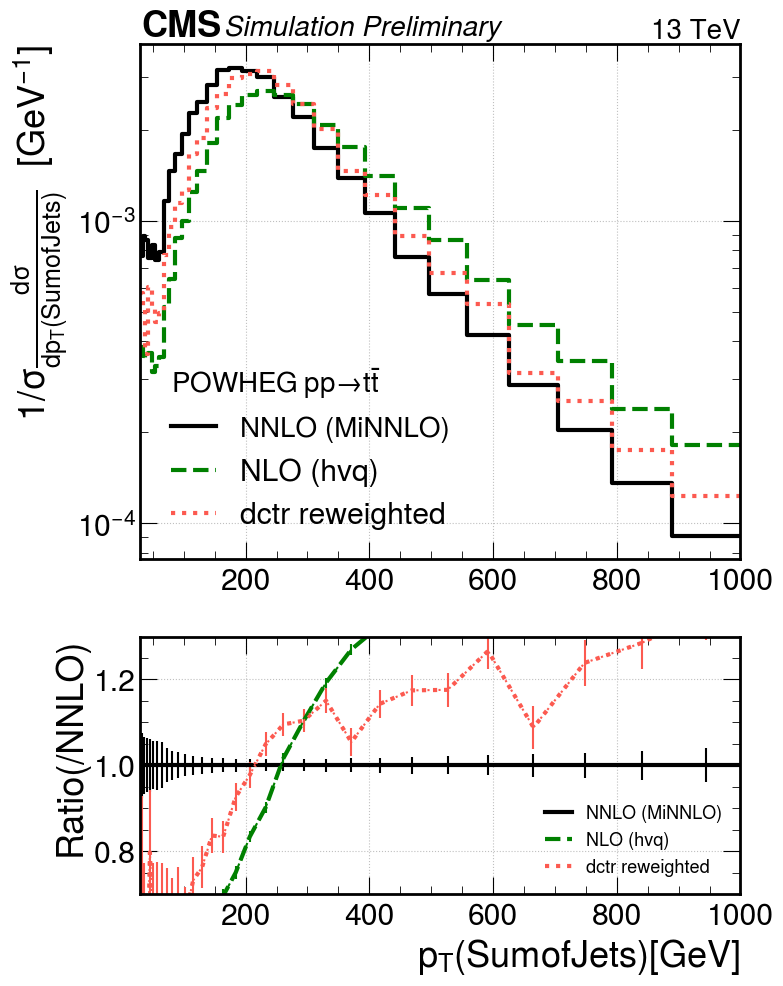

In [19]:
# sum of jet pt per event

X0_jet_pt_sums = []
for event in X0_jet:
    X0_jet_pt_sums.append(np.sum(event[:,0]))

X1_jet_pt_sums = []
for event in X1_jet:
    X1_jet_pt_sums.append(np.sum(event[:,0]))

    
print(f'{np.shape(X0_jet_pt_sums) = }')
print(f'{np.shape(X1_jet_pt_sums) = }')

log_bins = np.logspace(np.log10(10), np.log10(1000), 31)

args_jet_sum = [(np.array(X1_jet_pt_sums), X1_wgt, 'NNLO (MiNNLO)'),
                (np.array(X0_jet_pt_sums), X0_wgt, 'NLO (hvq)'),
                (np.array(X0_jet_pt_sums), rwgt, 'dctr reweighted')]

log_bins = np.logspace(np.log10(30), np.log10(1000), 31)

DCTR.plot_ratio_cms(args_jet_sum, bins = log_bins, y_scale = 'log', part_label='Sum of Jets', ratio_ylim=(0.7, 1.3))


